In [49]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np

from lmfit import minimize, Parameters, Model
from lmfit.models import GaussianModel, ExponentialModel, \
                         ThermalDistributionModel , StepModel#Modelli vari, l'ultimo è Fermi (o Bose)
from lmfit.model import Model, save_model

from uncertainties import ufloat

import pickle

In [50]:
channel= 2

In [51]:
#Tensione per considerare il segnale come saturato
Vt = np.array([-1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.5, -1.3, 
               -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3]) #V
#Carica per filtrare spike ed eventi triggerati male
Q_max = np.array([-30, -30, -30, -30, -30, -30, -30, -30, 
                  -30, -30, -30, -30, -30, -30, -30, -30, ]) #pC
#Carica per filtrare cosmici
Q_min = np.array([-1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, 
                  -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, ]) #pC

Vt = Vt[channel]
Q_max = Q_max[channel]
Q_min = Q_min[channel]

In [52]:
PATH = '../Dati/Dati_belli/Ch'+str(channel)+'/Run_ch' + str(channel) + '_Cs_Measurements_Only_3_27_2024.root' #Percorso relativo del file da analizzare
RunCs = uproot.open(PATH) #Apertura file da analizzare

noise_file = '../Dati/Dati_belli/Ch'+str(channel)+'/Run_ch' + str(channel) + '_X_Measurements_Only_4_5_2024_0000.root'  #File di rumore di riferimento per il canale
RunNoise = uproot.open(noise_file)  #Apertura rumore

noise_file2 = '../Dati/Dati_belli/Ch'+str(channel)+'/Run_ch' + str(channel) + '_X_Measurements_Only_3_21_2024.root'  #File di rumore di riferimento per il canale
RunNoise2=uproot.open(noise_file2) 

In [53]:
chargeCs = np.array(RunCs['tree'].arrays()['charge'])
ampCs = np.array(RunCs['tree'].arrays()['amp'])


chargeN = np.array(RunNoise['tree'].arrays()['charge'])
ampN = np.array(RunNoise['tree'].arrays()['amp'])
"""
chargeN = np.append(chargeN_, np.array(RunNoise2['tree'].arrays()['charge']))
ampN_ = np.array(RunNoise2['tree'].arrays()['amp'])
ampN=np.append(ampN_, np.array(RunNoise['tree'].arrays()['amp']))
"""
evCsT = np.array(RunCs['tree'].arrays()['ev'])[-1]
evNT = np.array(RunNoise['tree'].arrays()['ev'])[-1]
print(evCsT, evNT, len(chargeN), len(ampN))

1000000 500000 500000 500000


In [54]:
trueCs = ampCs>Vt  #Seleziono solo gli eventi che non saturano
chargeCs = chargeCs[trueCs]
ampCs=ampCs[trueCs]

trueCs = (chargeCs < Q_max) & (chargeCs > Q_min)
chargeCs = chargeCs[trueCs] #Seleziono solo gli eventi con una carica sotto una certa soglia
ampCs=ampCs[trueCs]         #così da trascurare spike ed eventi dovuti a trigger su altro canale


trueX = ampN>Vt             #Procedo allo stesso modo per "ripulire" il rumore
chargeN = chargeN[trueX]
ampN=ampN[trueX]

trueX = (chargeN < Q_max) & (chargeN > Q_min)
chargeN = chargeN[trueX]
ampN=ampN[trueX]

print("#Eventi ripuliti su ch " + str(channel) + " = " + str(len(chargeCs)))
print("#Noise ripulita su ch " + str(channel) + " = " + str(len(chargeN)))

#Eventi ripuliti su ch 2 = 801505
#Noise ripulita su ch 2 = 256621


AttributeError: module 'numpy' has no attribute 'stderrqrt'

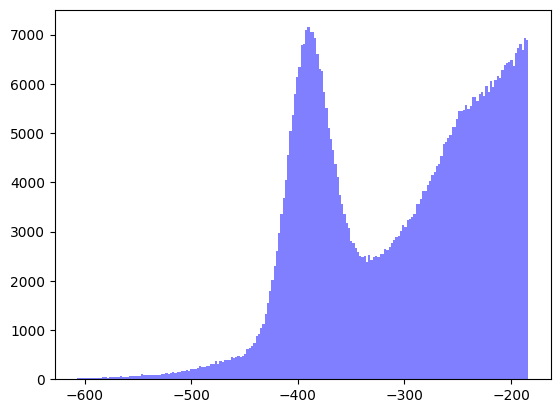

In [55]:
Nbin = 200
bin_lims = [int(Nbin *40 / 100), int(Nbin * 84/ 100)] #Scelgo gli estremi
_, edges, _ = plt.hist(chargeCs, bins = Nbin, color = "r")
plt.clf()
lims = [edges[bin_lims[0]], edges[bin_lims[1]]]
binCs, edgesCs, _ = plt.hist(chargeCs, bins = Nbin, range = lims, color = "b", alpha = 0.5)
centersCs = np.convolve(edgesCs, [0.5, 0.5], "valid")
errCs = np.stderrqrt(binCs)

plt.errorbar(centersCs, binCs, errCs, color = "red", fmt='|')
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("Counts")
plt.title("Rumore + sorgente")

plt.show()


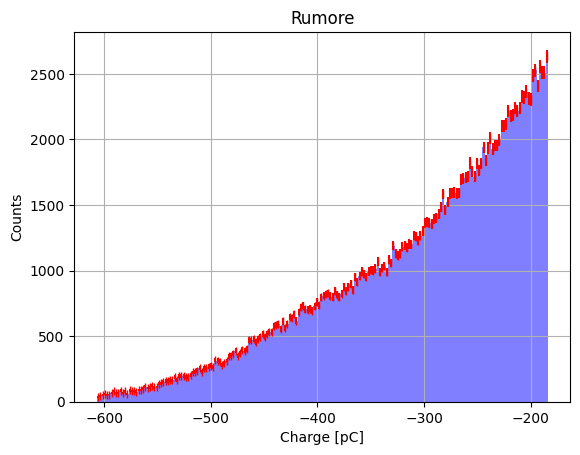

183605.0

In [56]:
binN, edgesN, _ = plt.hist(chargeN, bins = Nbin, range = lims, color = "b", alpha = 0.5)
centersN = np.convolve(edgesN, [0.5, 0.5], "valid")
errN = np.sqrt(binN)
plt.errorbar(centersN, binN, errN, color = "red", fmt='|')
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("Counts")
plt.title("Rumore")

plt.show()

binN.sum()

In [72]:
with open('/Users/martinachirico/Desktop/Sfera/DictNoise/NoisesDict_11_04.pkl', 'rb') as f:   #lista di dizionari
    x = pickle.load(f)  

In [73]:
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
gauss2 = GaussianModel(prefix='g2_')    #Gaussiana
s1    = StepModel(form = "logistic", prefix = "s1_") #Fermi Dirac1
s2    = StepModel(form = "logistic", prefix = "s2_") #Fermi Dirac

params=x[channel]
print(type(params))
params.pretty_print()
print(params["e1_amplitude"].stderr)


def to_ufloat(var):
    return ufloat(var.value, var.stderr)

def get_constraints(r, n_sigma):
    r["e1_decay"].set(value=r["e1_decay"].value, min=r["e1_decay"].value-n_sigma*r["e1_decay"].stderr, max=r["e1_decay"].value+n_sigma*r["e1_decay"].stderr )
    r["s1_center"].set ( value=r["s1_center"].value, min=r["s1_center"].value-n_sigma*r["s1_center"].stderr, max=r["s1_center"].value+n_sigma*r["s1_center"].stderr)
    r["s1_sigma"].set(value=r["s1_sigma"].value, min=r["s1_sigma"].value-n_sigma*r["s1_sigma"].stderr, max=r["s1_sigma"].value+n_sigma*r["s1_sigma"].stderr )
    r["ratio"].set( vary=True, min=r["ratio"].value-n_sigma*r["ratio"].stderr, max=r["ratio"].value+n_sigma*r["ratio"].stderr)  
    r["s1_amplitude"].set(expr="e1_amplitude/ratio")
    n_sigma=5
    return r


params=get_constraints(params, n_sigma=5)
params.pretty_print()


<class 'lmfit.parameter.Parameters'>
Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
e1_amplitude      6671     -inf      inf    96.25     True     None     None
e1_decay        -101.3     -inf      inf   0.7019     True     None     None
ratio            24.68     -inf      inf   0.7849    False e1_amplitude / s1_amplitude     None
s1_amplitude     270.2        0      inf    7.202     True     None     None
s1_center       -424.3     -inf      inf    1.555     True     None     None
s1_sigma         30.59        0      inf    1.144     True     None     None
96.25271284820064
Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
e1_amplitude      6671     -inf      inf    96.25     True     None     None
e1_decay        -101.3   -104.8    -97.8   0.7019     True     None     None
ratio            24.68    20.76    28.61   0.7849     True     None     None
s1_amplitude     270.2        0      inf    7.202    False e1_amplitude/rat

Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
e1_amplitude      1000     -inf      inf    96.25     True     None     None
e1_decay        -101.3   -104.8    -97.8   0.7019     True     None     None
g2_amplitude  2.442e+06     -inf      inf     None     True     None     None
g2_center         -388     -inf      inf     None     True     None     None
g2_fwhm          44.74     -inf      inf     None    False 2.3548200*g2_sigma     None
g2_height     5.128e+04     -inf      inf     None    False 0.3989423*g2_amplitude/max(1e-15, g2_sigma)     None
g2_sigma            19        0      inf     None     True     None     None
ratio            24.68    20.76    28.61   0.7849     True     None     None
s1_amplitude     40.51        0      inf    7.202    False e1_amplitude/ratio     None
s1_center       -424.3     -432   -416.5    1.555     True     None     None
s1_sigma         30.59    24.87     36.3    1.144     True     None     None
s2_amplitude     

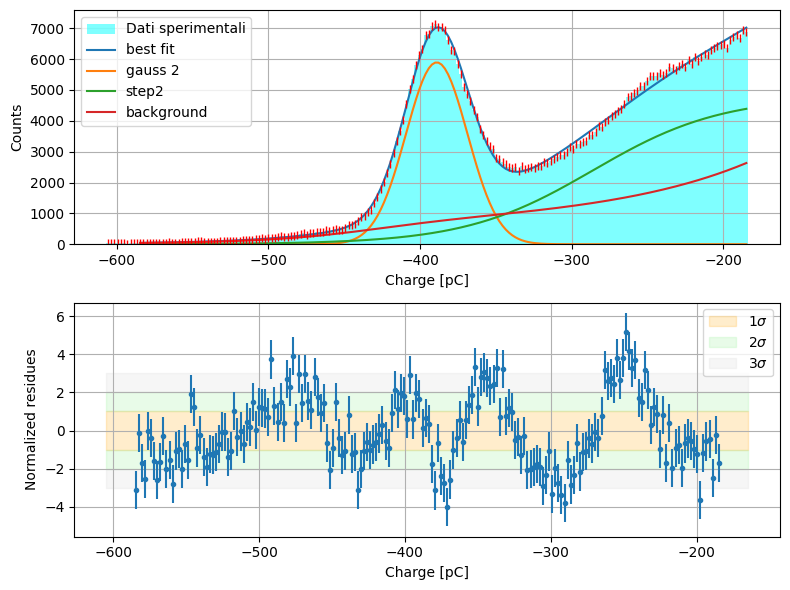

[[Model]]
    (((Model(exponential, prefix='e1_') + Model(step, prefix='s1_', form='logistic')) + Model(gaussian, prefix='g2_')) + Model(step, prefix='s2_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1477
    # data points      = 190
    # variables        = 11
    chi-square         = 668.174285
    reduced chi-square = 3.73281724
    Akaike info crit   = 260.929745
    Bayesian info crit = 296.647010
    R-squared          = 0.99999941
##  Warning: uncertainties could not be estimated:
    e1_decay:      at boundary
    s1_center:     at boundary
    ratio:         at boundary
[[Variables]]
    e1_amplitude:  13215.6497 (init = 1000)
    e1_decay:     -97.8026132 (init = -101.312)
    s1_amplitude:  636.612376 == 'e1_amplitude/ratio'
    s1_center:    -432.045070 (init = -424.271)
    s1_sigma:      33.6339506 (init = 30.58651)
    ratio:         20.7593351 (init = 24.68386)
    g2_amplitude:  299869.647 (init = 2442417)
    g2_cent

In [83]:

#params["e1_decay"].set(value=r.uvars["e1_decay"].n, min=r.uvars["e1_decay"].n-n_sigma*r.uvars["e1_decay"].s, max=r.uvars["e1_decay"].n+n_sigma*r.uvars["e1_decay"].s)
params["e1_amplitude"].set(value=1000)

params.update(gauss2.guess(binCs, x=centersCs))
params["g2_amplitude"].set(vary = True)
params["g2_center"].set(value= -388, vary = True)
params["g2_sigma"].set(value=19, vary = True)

params.update(s2.make_params(amplitude = 0, center = -200, sigma = 50))
params["s2_amplitude"].set( value=1000, min=0,  vary=True) #"""value=921"""
params["s2_center"].set(value=-250,  vary=True)
params["s2_sigma"].set(value=5,  vary=True)

#params["s1_amplitude"].set(vary = True, expr='e1_amplitude/'+str(frac))
#params["s1_amplitude"].set(vary = True, expr='e1_amplitude/frac')
#params["s1_center"].set(value=r.uvars["s1_center"].n, min=r.uvars["s1_center"].n-n_sigma*r.uvars["s1_center"].s, max=r.uvars["s1_center"].n+n_sigma*r.uvars["s1_center"].s)
#params["s1_sigma"].set(value=r.uvars["s1_sigma"].n, min=r.uvars["s1_sigma"].n-n_sigma*r.uvars["s1_sigma"].s, max=r.uvars["s1_sigma"].n+n_sigma*r.uvars["s1_sigma"].s)


model = exp1 + s1 + gauss2 +s2

params.pretty_print()

start=int(Nbin *5/ 100)
stop=int(Nbin * 100/ 100)

# Fit the model to the data
result = model.fit(binCs[start:stop], params, x = centersCs[start:stop], weights = 1/errCs[start:stop])


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeCs, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Dati sperimentali")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.errorbar(centersCs, binCs, errCs, color = "red", fmt='|', linewidth=.6)
ax1.plot(centersCs[start:stop], result.best_fit, label='best fit')
#ax1.plot(centersCs[start:stop], comps['e1_'],'.-',label='exp 1')
#ax1.plot(centersCs[start:stop], comps['s1_'], '.-', label='step 1')
ax1.plot(centersCs[start:stop], comps['g2_'], label='gauss 2')
ax1.plot(centersCs[start:stop], comps['s2_'], label='step2')
ax1.plot(centersCs[start:stop], comps['s1_']+comps['e1_'], label='background')



ax1.legend()
ax1.grid()

residueCs = binCs[start:stop] - result.best_fit
norm_resCs = residueCs / errCs[start:stop]

ax2.errorbar(centersCs[start:stop], norm_resCs, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result.fit_report())

In [ ]:
params.add("frac", value = frac.n, min=frac.n-n_sigma*frac.s, max=frac.n +n_sigma*frac.s)
print(params["frac"])
params.update(result.params)
r=result

frac=to_ufloat(result.uvars["e1_amplitude"] / to_ufloat(result.uvars["s1_amplitude"]))
print("rapporto tra le ampiezze di exp e fermi dirac", frac)

# Vecchio fit del rumore

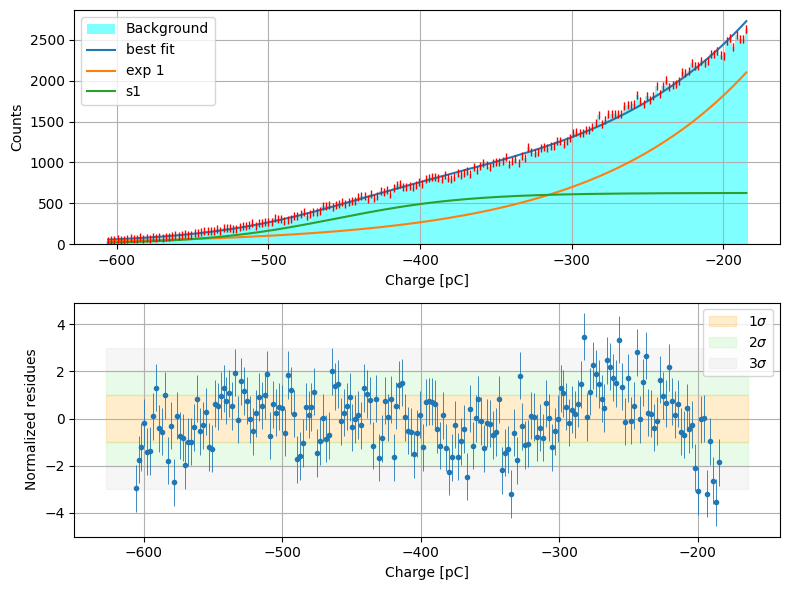

[[Model]]
    (Model(exponential, prefix='e1_') + Model(step, prefix='s1_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 98
    # data points      = 200
    # variables        = 5
    chi-square         = 312.227945
    reduced chi-square = 1.60116895
    Akaike info crit   = 99.0832293
    Bayesian info crit = 115.574816
    R-squared          = 0.99999701
[[Variables]]
    e1_amplitude:  12334.5386 +/- 714.775621 (5.79%) (init = 18356.11)
    e1_decay:     -104.482254 +/- 4.79111514 (4.59%) (init = -114.6268)
    g2_amplitude:  2442417 (fixed)
    g2_center:    -288.0907 (fixed)
    g2_sigma:      114.201 (fixed)
    g2_fwhm:       268.922844 +/- 0.00000000 (0.00%) == '2.3548200*g2_sigma'
    g2_height:     8532.17897 +/- 0.00000000 (0.00%) == '0.3989423*g2_amplitude/max(1e-15, g2_sigma)'
    s1_amplitude:  627.736697 +/- 62.4765290 (9.95%) (init = 100)
    s1_center:    -455.329142 +/- 3.42570038 (0.75%) (init = -380)
    s1_sigma:  

In [31]:
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
#gauss1 = GaussianModel(prefix='g1_')    #Gaussiana
gauss2 = GaussianModel(prefix='g2_')    #Gaussiana
s1    = StepModel(form = "logistic", prefix = "s1_") #Fermi Dirac1
s2    = StepModel(form = "logistic", prefix = "s2_") #Fermi Dirac



 
params = exp1.guess(binN, x=centersN)           #Inizializzo i parametri dell'esponenziale
#params.update(gauss1.guess(binN, x=centersN))   #Indovina i parametri della prima gaussiana
params.update(gauss2.make_params(amplitude = 1000, center = -370, sigma = 25)) #Imposta la seconda gaussiana con A = 0 (necessario per primo fit)
params.update(gauss2.guess(binCs, x=centersCs))
params.update(s1.make_params(amplitude = 100, center = -380, sigma = 50))    #Imposta la Fermi Dirac con A = 0 (necessario per primo fit)
#params.update(gauss1.guess(binN, x=centersN)) 
params.update(s2.make_params(amplitude = 0, center = -200, sigma = 50))



params["g2_amplitude"].vary = False    #Blocco i parametri della seconda gaussiana e della 
params["g2_center"].vary = False       #Fermi Dirac: non servono nel primo fit
params["g2_sigma"].vary = False

params["s2_amplitude"].vary= False
params["s2_center"].vary=False
params["s2_sigma"].vary=False

params["e1_amplitude"].min=0
params["s1_sigma"].set(value=20, min=0)

model = exp1 + s1 

# Fit the model to the data
result = model.fit(binN, params, x = centersN, weights = 1/errN, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeN, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersN, result.best_fit, label='best fit')
ax1.plot(centersN, comps['e1_'], label='exp 1')
ax1.plot(centersN, comps['s1_'], label='s1')


ax1.legend()
ax1.errorbar(centersN, binN, errN, color = "red", fmt='|', linewidth=0.5)
ax1.grid()

residueN = binN - result.best_fit
norm_resN = residueN / errN

ax2.errorbar(centersN, norm_resN, 1, ls = "", marker = ".", linewidth=.6)
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()
print(result.fit_report())

def to_ufloat(var):
    return ufloat(var.n, var.s)


frac=to_ufloat(result.uvars["e1_amplitude"] / to_ufloat(result.uvars["s1_amplitude"]))
print("rapporto tra le ampiezze di exp e fermi dirac", frac)
n_sigma=5
params.add("frac", value = frac.n, min=frac.n-n_sigma*frac.s, max=frac.n +n_sigma*frac.s)
print(params["frac"])
params.update(result.params)
r=result


Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
e1_amplitude      1000        0      inf    714.8     True     None     None
e1_decay        -104.5   -128.4   -80.53    4.791     True     None     None
frac             19.65    8.334    30.96     None     True     None     None
g2_amplitude  2.442e+06     -inf      inf        0     True     None     None
g2_center         -388     -inf      inf        0     True     None     None
g2_fwhm          44.74     -inf      inf        0    False 2.3548200*g2_sigma     None
g2_height     5.128e+04     -inf      inf        0    False 0.3989423*g2_amplitude/max(1e-15, g2_sigma)     None
g2_sigma            19        0      inf        0     True     None     None
s1_amplitude     50.89     -inf      inf    62.48    False e1_amplitude/frac     None
s1_center       -455.3   -472.5   -438.2    3.426     True     None     None
s1_sigma         43.22    25.57    60.87     3.53     True     None     None
s2_amplitude      

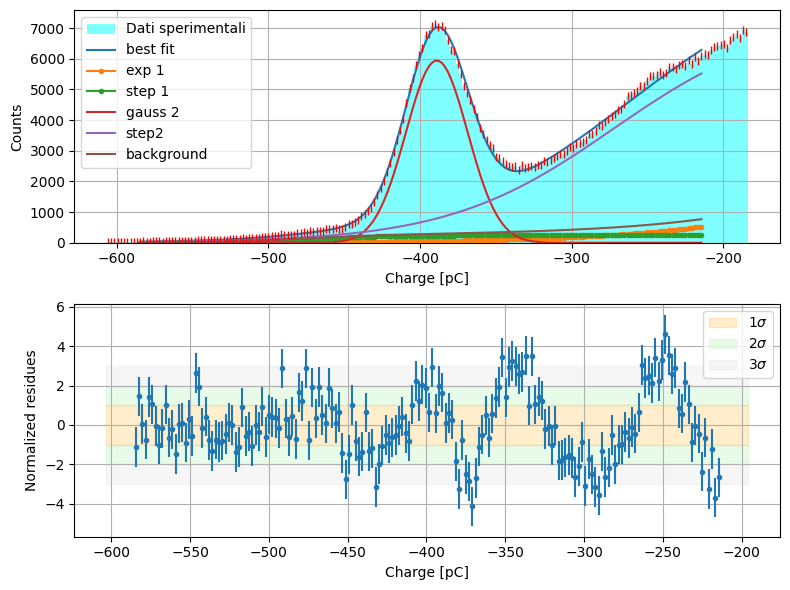

[[Model]]
    (((Model(exponential, prefix='e1_') + Model(step, prefix='s1_', form='logistic')) + Model(gaussian, prefix='g2_')) + Model(step, prefix='s2_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 594
    # data points      = 176
    # variables        = 11
    chi-square         = 527.692155
    reduced chi-square = 3.19813428
    Akaike info crit   = 215.253118
    Bayesian info crit = 250.128442
    R-squared          = 0.99999943
[[Variables]]
    e1_amplitude:  7532.62220 +/- 29536.0188 (392.11%) (init = 1000)
    e1_decay:     -80.5266796 +/- 1.3411e+08 (166544125.32%) (init = -104.4823)
    g2_amplitude:  303165.626 +/- 5152.22241 (1.70%) (init = 2442417)
    g2_center:    -388.968217 +/- 0.14455118 (0.04%) (init = -388)
    g2_sigma:      20.3415275 +/- 0.21336628 (1.05%) (init = 19)
    g2_fwhm:       47.9006357 +/- 0.50243919 (1.05%) == '2.3548200*g2_sigma'
    g2_height:     5945.74779 +/- 59.7780714 (1.01%) == '0.398942

In [100]:

params["e1_decay"].set(value=r.uvars["e1_decay"].n, min=r.uvars["e1_decay"].n-n_sigma*r.uvars["e1_decay"].s, max=r.uvars["e1_decay"].n+n_sigma*r.uvars["e1_decay"].s)
params["e1_amplitude"].set(value=1000)

params["g2_amplitude"].set(vary = True)
params["g2_center"].set(value= -388, vary = True)
params["g2_sigma"].set(value=19, vary = True)

params["s2_amplitude"].set( value=1000, min=0,  vary=True) #"""value=921"""
params["s2_center"].set(value=-250,  vary=True)
params["s2_sigma"].set(value=5,  vary=True)

#params["s1_amplitude"].set(vary = True, expr='e1_amplitude/'+str(frac))
params["s1_amplitude"].set(vary = True, expr='e1_amplitude/frac')
params["s1_center"].set(value=r.uvars["s1_center"].n, min=r.uvars["s1_center"].n-n_sigma*r.uvars["s1_center"].s, max=r.uvars["s1_center"].n+n_sigma*r.uvars["s1_center"].s)
params["s1_sigma"].set(value=r.uvars["s1_sigma"].n, min=r.uvars["s1_sigma"].n-n_sigma*r.uvars["s1_sigma"].s, max=r.uvars["s1_sigma"].n+n_sigma*r.uvars["s1_sigma"].s)


model = exp1 + s1 + gauss2 +s2

params.pretty_print()

start=int(Nbin *5/ 100)
stop=int(Nbin * 93/ 100)

# Fit the model to the data
result = model.fit(binCs[start:stop], params, x = centersCs[start:stop], weights = 1/errCs[start:stop])


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeCs, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Dati sperimentali")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.errorbar(centersCs, binCs, errCs, color = "red", fmt='|', linewidth=.6)
ax1.plot(centersCs[start:stop], result.best_fit, label='best fit')
ax1.plot(centersCs[start:stop], comps['e1_'],'.-',label='exp 1')
ax1.plot(centersCs[start:stop], comps['s1_'], '.-', label='step 1')
ax1.plot(centersCs[start:stop], comps['g2_'], label='gauss 2')
ax1.plot(centersCs[start:stop], comps['s2_'], label='step2')
ax1.plot(centersCs[start:stop], comps['s1_']+comps['e1_'], label='background')



ax1.legend()
ax1.grid()

residueCs = binCs[start:stop] - result.best_fit
norm_resCs = residueCs / errCs[start:stop]

ax2.errorbar(centersCs[start:stop], norm_resCs, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result.fit_report())